In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
from scipy.integrate import quad
from scipy.optimize import minimize
import time

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 28}
font1 = {'family': 'serif', 'size': 24}

Defining RM function 


In [2]:
def proj(x,low=-5,high=5):

    x = np.clip(x, low, high)
    return x

def prox_l1(x, eta=1e-4, c=1e-4):
    threshold = c / eta
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def grad(func,x,mu=0.05):
    u = np.random.normal(0,1, size=len(x))
    g = (func(x+mu*u)-func(x))/mu
    return g*u


def step(func,x,h,mu=0.05):
    grd = grad(func,x,mu)
    xx = x - h*grd
    return xx

def RM(func,x0,T,h = 0.001,mu=0.05,flag2 = 'not_c',proj=None):
    dim1 = len(x0)
    x=np.zeros((dim1,T+1))
    x[:,0]=x0.ravel()
    if flag2 == 'not_c':
        for k in range(T):
          x[:,k+1] = step(func,x[:,k],h,mu)
    if flag2 == 'c':
        for k in range(T):
          x[:,k+1] =proj(step(func,x[:,k],h,mu))
    return x

def f(x):
    return np.sum(x**4 + x**2 - x)
x0 = np.array([5, -5])
print("final X with g",RM(f,x0,10000,h = 0.001,mu=0.005)[:,-1])

final X with g [0.38581641 0.38560369]


The GLM test. First Sigmoid

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


num_iterations = 20000
num_iterations2 = 20000
learning_rate = 0.01
d = 50
n = 1000
MC = 20
execution_time = []
execution_time2 = []
f1_s = np.zeros((num_iterations,MC))
losses_s = np.zeros((num_iterations2,MC))
for j in range(MC):
    w_0 = 0.01*np.random.randn(d)
    X = np.random.randn(n, d)
    w_star = np.random.randn(d)
    y = sigmoid(np.dot(X, w_star))

    def loss_function(w):
        predictions = sigmoid(np.dot(X, w))
        loss = 0.5 * np.mean((predictions - y) ** 2)
        return loss
    def gradientt(w, X, y):
        n = len(y)
        predictions = sigmoid(np.dot(X, w))
        return (1/n) * np.dot(X.T, (predictions - y) * predictions * (1 - predictions))

    start = time.time()
    ww=RM(loss_function,w_0,num_iterations,h = 0.01,mu=0.0005)
    end = time.time()
    execution_time.append(end-start)
    
    for i in range(num_iterations):
        f1_s[i,j] = loss_function(ww[:,i])
    
    w = np.zeros((num_iterations2,d))
    w[0,:]=w_0


    start = time.time()
    for i in range(num_iterations2-1):
        # Compute gradient
        gradd = gradientt(w[i,:], X, y)
        # Update weights
        w[i+1,:] =w[i,:]-learning_rate * gradd
        # Compute loss
    end = time.time()
    execution_time2.append(end-start)

    for i in range(num_iterations2):
        # Compute loss
        current_loss = loss_function(w[i,:])
        losses_s[i,j] =current_loss
    


In [23]:
et_s = np.mean(execution_time)
et2_s = np.mean(execution_time2)
tim_s = np.linspace(0,et_s,num_iterations)
tim2_s = np.linspace(0,et2_s,num_iterations2)
f1_sm = np.mean(f1_s,axis=1)
losses_sm = np.mean(losses_s,axis=1)
f1_s_se = np.std(f1_s, axis=1)
losses_s_se = np.std(losses_s, axis=1)

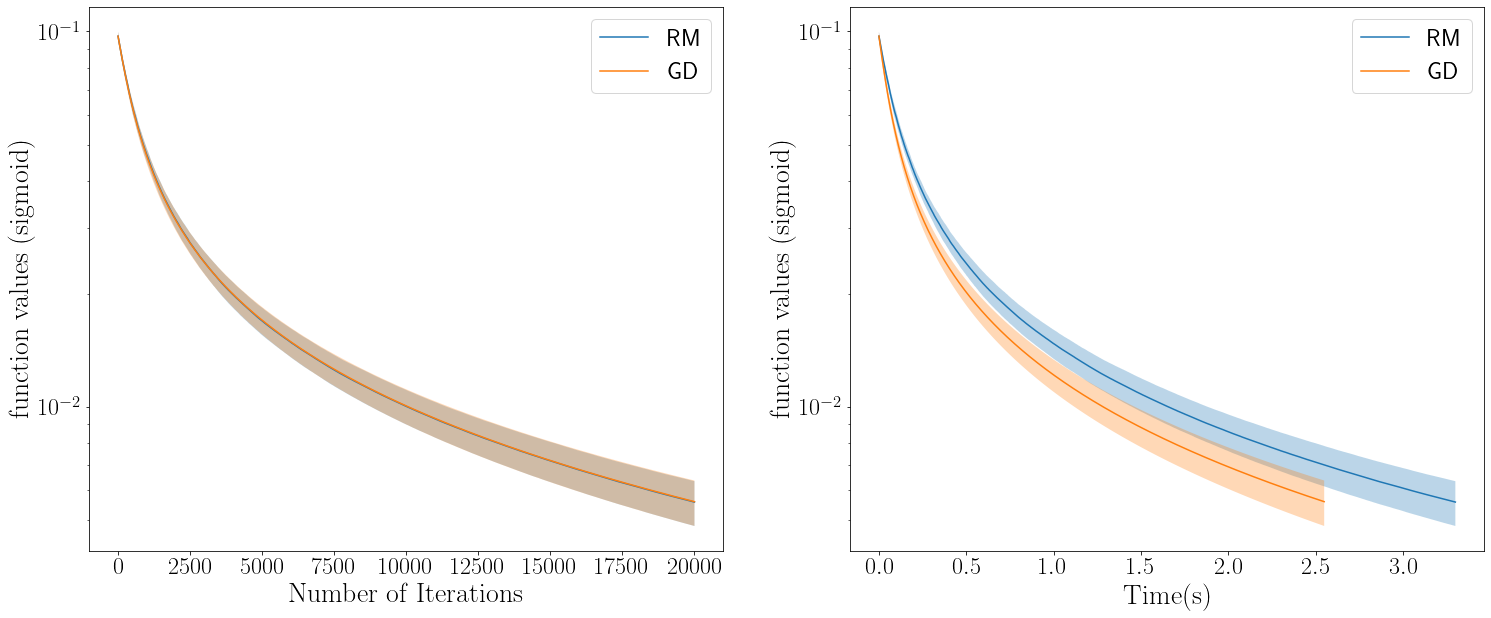

In [24]:
t_s = np.array(range(num_iterations))
t2_s = np.array(range(num_iterations2))
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=24, color='black')
plt.yticks(fontname='serif', fontsize=24, color='black')
plt.plot(t_s,f1_sm,label= 'RM')
plt.plot(t2_s,losses_sm,label= 'GD')

plt.fill_between(t_s, f1_sm - f1_s_se, f1_sm + f1_s_se, alpha=0.3)
plt.fill_between(t2_s, losses_sm - losses_s_se, losses_sm + losses_s_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(sigmoid)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
# plt.savefig('NeurIPS2024/Pics/sigmoid_iter.pdf', format='pdf')
plt.subplot(1, 2, 2)

plt.xticks(fontname='serif', fontsize=24, color='black')
plt.yticks(fontname='serif', fontsize=24, color='black')
plt.plot(tim_s,f1_sm,label= 'RM')
plt.plot(tim2_s,losses_sm,label= 'GD')

plt.fill_between(tim_s, f1_sm - f1_s_se, f1_sm + f1_s_se, alpha=0.3)
plt.fill_between(tim2_s, losses_sm - losses_s_se, losses_sm + losses_s_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Time(s)}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(sigmoid)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.savefig('NeurIPS2024/Pics/sigmoid.pdf', format='pdf')

ReLU

In [51]:
def relu(x):
    return np.maximum(0, x)

# Define derivative of ReLU function
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

num_iterations = 6000
learning_rate = 0.01
num_iterations2 = 6000
d = 50
n = 1000
MC =20
execution_time = []
execution_time2 = []
f1_r = np.zeros((num_iterations,MC))
losses_r = np.zeros((num_iterations2,MC))
for j in range(MC):
    w_0 = 0.01*np.random.randn(d)
    X = np.random.randn(n, d)
    w_star = np.random.randn(d)
    y = relu(np.dot(X, w_star))
    # Define function to compute gradient
    def compute_gradient(w, X, y):
        n = X.shape[0]
        error = relu(np.dot(X, w)) - y
        gradient = np.dot(X.T, error * relu_derivative(np.dot(X, w))) / n
        return gradient
    def loss_function(w):
        predictions = relu(np.dot(X, w))
        loss = 0.5 * np.mean((predictions - y) ** 2)
        return loss
    start = time.time()
    ww=RM(loss_function,w_0,num_iterations,h = 0.01,mu=0.0001)
    end = time.time()
    execution_time.append(end-start)

    for i in range(num_iterations):
        f1_r[i,j] = loss_function(ww[:,i])

    w = np.zeros((num_iterations2,d))
    w[0,:]=w_0
    # Gradient Descent
    start = time.time()
    for i in range(num_iterations2-1):
        # Compute gradient
        gradd = compute_gradient(w[i,:], X, y)
        # Update weights
        w[i+1,:] =w[i,:]-learning_rate * gradd
        # Compute loss
    end = time.time()
    execution_time2.append(end-start)

    for i in range(num_iterations2):
        # Compute loss
        current_loss = loss_function(w[i,:])
        losses_r[i,j] =current_loss

In [52]:
et_r = np.mean(execution_time)
et2_r = np.mean(execution_time2)
tim_r = np.linspace(0,et_r,num_iterations)
tim2_r = np.linspace(0,et2_r,num_iterations2)
f1_rm = np.mean(f1_r,axis=1)
losses_rm = np.mean(losses_r,axis=1)
f1_r_se = np.std(f1_r, axis=1)
losses_r_se = np.std(losses_r, axis=1)

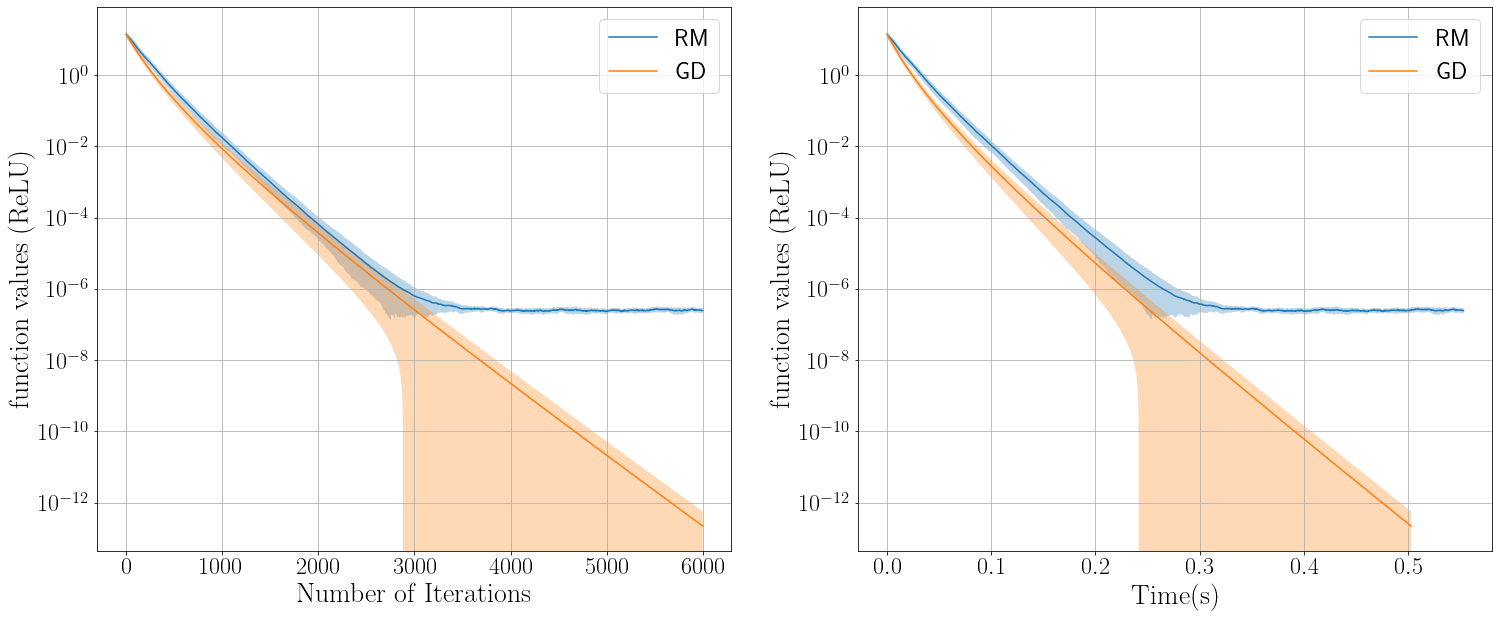

In [53]:
t_r = np.array(range(num_iterations))
t2_r = np.array(range(num_iterations2))
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=24, color='black')
plt.yticks(fontname='serif', fontsize=24, color='black')
plt.plot(t_r,f1_rm,label= 'RM')
plt.plot(t2_r,losses_rm,label= 'GD')

plt.fill_between(t_r, f1_rm - f1_r_se, f1_rm + f1_r_se, alpha=0.3)
plt.fill_between(t2_r, losses_rm - losses_r_se, losses_rm + losses_r_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(ReLU)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.grid('on')
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=24, color='black')
plt.yticks(fontname='serif', fontsize=24, color='black')
plt.plot(tim_r,f1_rm,label= 'RM')
plt.plot(tim2_r,losses_rm,label= 'GD')

plt.fill_between(tim_r, f1_rm - f1_r_se, f1_rm + f1_r_se, alpha=0.3)
plt.fill_between(tim2_r, losses_rm - losses_r_se, losses_rm + losses_r_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Time(s)}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(ReLU)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.grid('on')
plt.savefig('NeurIPS2024/Pics/relu.pdf', format='pdf')

Leaky ReLU

In [40]:
alpha = 0.1
def leaky_relu(x):
    return np.maximum(alpha*x, x)

# Define derivative of Leaky ReLU function
def leaky_relu_derivative(x, alpha=0.1):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

num_iterations = 6000
learning_rate = 0.01
num_iterations2 = 6000
d = 50
n = 1000
MC =20
execution_time = []
execution_time2 = []
f1_l = np.zeros((num_iterations,MC))
losses_l = np.zeros((num_iterations2,MC))
for j in range(MC):
    w_0 = 0.01*np.random.randn(d)
    X = np.random.randn(n, d)
    w_star = np.random.randn(d)
    y = leaky_relu(np.dot(X, w_star))
    # Define function to compute gradient
    def compute_gradient(w, X, y, alpha=0.1):
        n = X.shape[0]
        error = leaky_relu(np.dot(X, w)) - y
        gradient = np.dot(X.T, error * leaky_relu_derivative(np.dot(X, w), alpha)) / n
        return gradient

    # Define function to minimize
    def loss_function(w):
        n = X.shape[0]
        error = leaky_relu(np.dot(X, w)) - y
        loss = 0.5 * np.mean(np.square(error))
        return loss
    
    start = time.time()
    ww=RM(loss_function,w_0,num_iterations,h = 0.01,mu=0.0001)
    end = time.time()
    execution_time.append(end-start)

    for i in range(num_iterations):
        f1_l[i,j] = loss_function(ww[:,i])

    w = np.zeros((num_iterations2,d))
    w[0,:]=w_0
    # Gradient Descent
    start = time.time()
    for i in range(num_iterations2-1):
        # Compute gradient
        gradd = compute_gradient(w[i,:], X, y)
        # Update weights
        w[i+1,:] =w[i,:]-learning_rate * gradd
        # Compute loss
    end = time.time()
    execution_time2.append(end-start)

    for i in range(num_iterations2):
        # Compute loss
        current_loss = loss_function(w[i,:])
        losses_l[i,j] =current_loss

In [41]:
et_l = np.mean(execution_time)
et2_l = np.mean(execution_time2)
tim_l = np.linspace(0,et_l,num_iterations)
tim2_l = np.linspace(0,et2_l,num_iterations2)
f1_lm = np.mean(f1_l,axis=1)
losses_lm = np.mean(losses_l,axis=1)
f1_l_se = np.std(f1_l, axis=1)
losses_l_se = np.std(losses_l, axis=1)

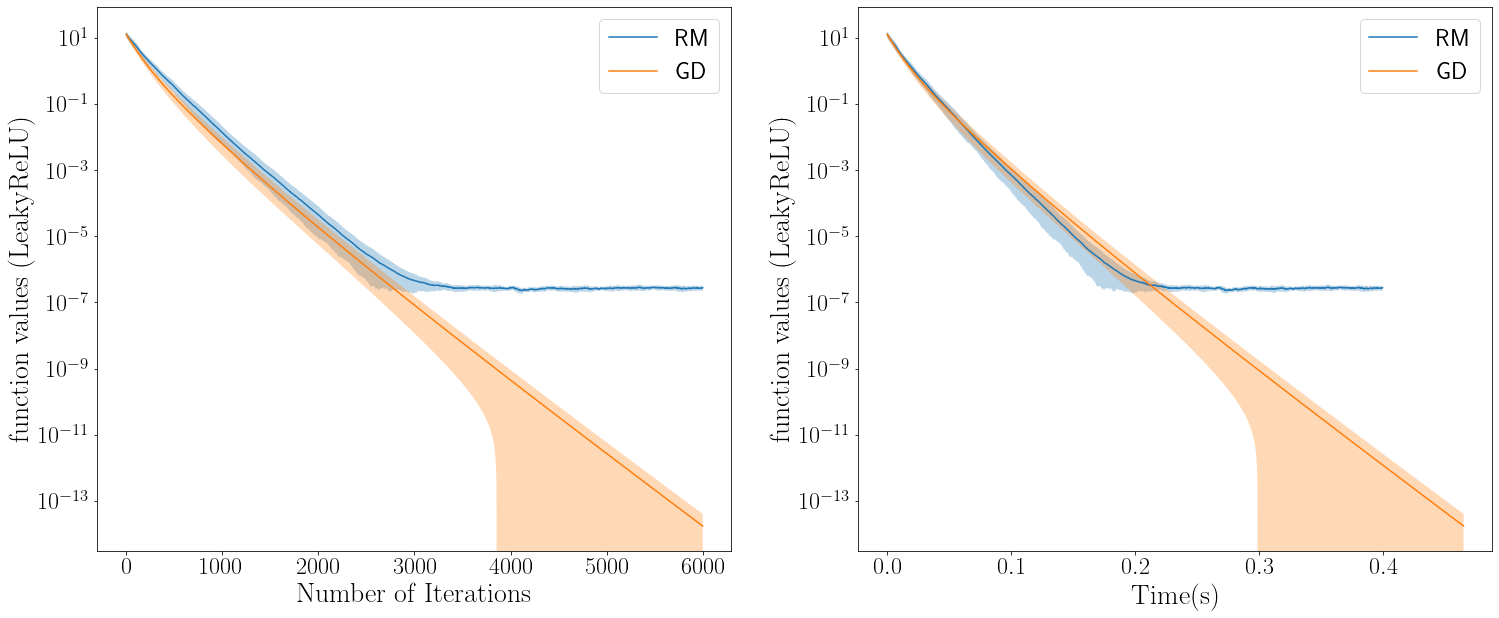

In [42]:
t_l = np.array(range(num_iterations))
t2_l = np.array(range(num_iterations2))
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=24, color='black')
plt.yticks(fontname='serif', fontsize=24, color='black')
plt.plot(t_l,f1_lm,label= 'RM')
plt.plot(t2_l,losses_lm,label= 'GD')

plt.fill_between(t_l, f1_lm - f1_l_se, f1_lm + f1_l_se, alpha=0.3)
plt.fill_between(t2_l, losses_lm - losses_l_se, losses_lm + losses_l_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(Leaky ReLU)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=24, color='black')
plt.yticks(fontname='serif', fontsize=24, color='black')
plt.plot(tim_l,f1_lm,label= 'RM')
plt.plot(tim2_l,losses_lm,label= 'GD')

plt.fill_between(tim_l, f1_lm - f1_l_se, f1_lm + f1_l_se, alpha=0.3)
plt.fill_between(tim2_l, losses_lm - losses_l_se, losses_lm + losses_l_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Time(s)}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(Leaky ReLU)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.savefig('NeurIPS2024/Pics/leakyrelu.pdf', format='pdf')

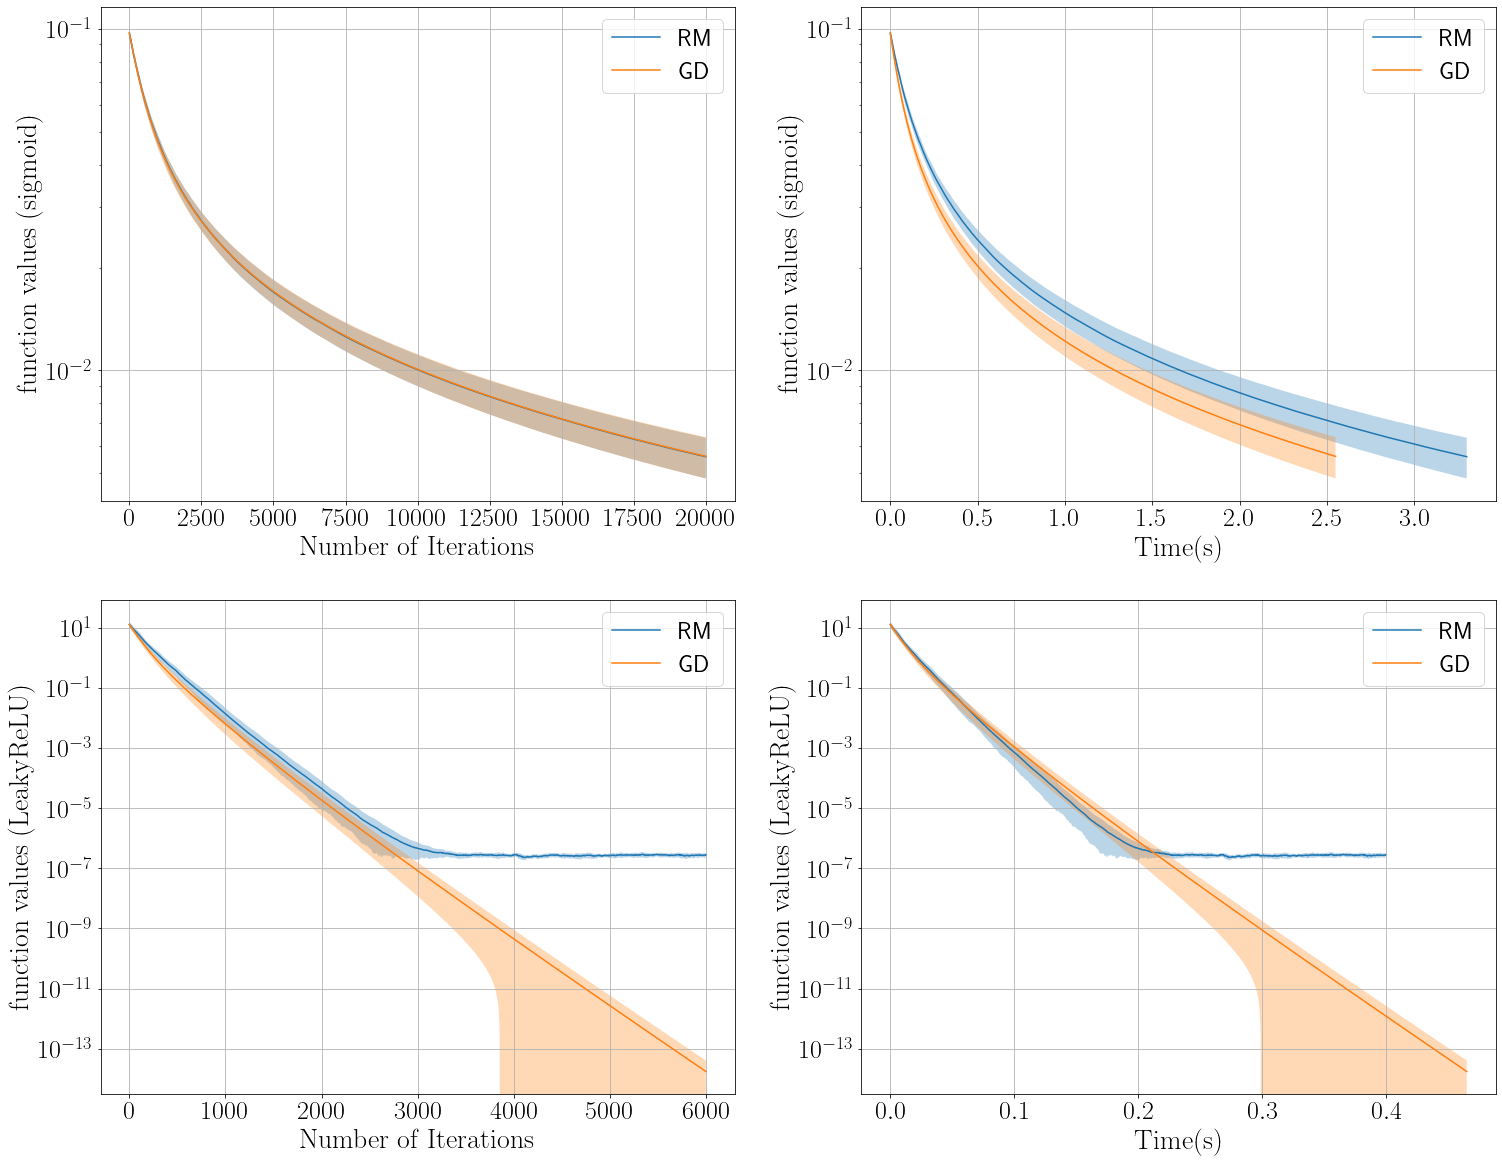

In [49]:

plt.figure(figsize=(25,20))
plt.subplot(2, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t_s,f1_sm,label= 'RM')
plt.plot(t2_s,losses_sm,label= 'GD')
plt.fill_between(t_s, f1_sm - f1_s_se, f1_sm + f1_s_se, alpha=0.3)
plt.fill_between(t2_s, losses_sm - losses_s_se, losses_sm + losses_s_se, alpha=0.3)
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(sigmoid)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.grid('on')
# plt.savefig('NeurIPS2024/Pics/sigmoid_iter.pdf', format='pdf')
plt.subplot(2, 2, 2)

plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(tim_s,f1_sm,label= 'RM')
plt.plot(tim2_s,losses_sm,label= 'GD')
plt.fill_between(tim_s, f1_sm - f1_s_se, f1_sm + f1_s_se, alpha=0.3)
plt.fill_between(tim2_s, losses_sm - losses_s_se, losses_sm + losses_s_se, alpha=0.3)
plt.xlabel(r'$\mathrm{Time(s)}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(sigmoid)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.grid('on')

# plt.subplot(3, 2, 3)
# plt.xticks(fontname='serif', fontsize=22, color='black')
# plt.yticks(fontname='serif', fontsize=22, color='black')
# plt.plot(t_r,f1_rm,label= 'RM')
# plt.plot(t2_r,losses_rm,label= 'GD')
# plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=24)
# plt.ylabel(r'$\mathrm{function\; values\;(ReLU)}$', fontdict=font)
# plt.yscale('log')
# # plt.xscale('log')
# plt.legend(loc='best', prop=font1)

# plt.subplot(3, 2, 4)
# plt.xticks(fontname='serif', fontsize=22, color='black')
# plt.yticks(fontname='serif', fontsize=22, color='black')
# plt.plot(tim_r,f1_rm,label= 'RM')
# plt.plot(tim2_r,losses_rm,label= 'GD')
# plt.xlabel(r'$\mathrm{Time(s)}$', fontsize=24)
# plt.ylabel(r'$\mathrm{function\; values\;(ReLU)}$', fontdict=font)
# plt.yscale('log')
# # plt.xscale('log')
# plt.legend(loc='best', prop=font1)



plt.subplot(2, 2, 3)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t_l,f1_lm,label= 'RM')
plt.plot(t2_l,losses_lm,label= 'GD')
plt.fill_between(t_l, f1_lm - f1_l_se, f1_lm + f1_l_se, alpha=0.3)
plt.fill_between(t2_l, losses_lm - losses_l_se, losses_lm + losses_l_se, alpha=0.3)
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(Leaky ReLU)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.grid('on')

plt.subplot(2, 2, 4)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(tim_l,f1_lm,label= 'RM')
plt.plot(tim2_l,losses_lm,label= 'GD')
plt.fill_between(tim_l, f1_lm - f1_l_se, f1_lm + f1_l_se, alpha=0.3)
plt.fill_between(tim2_l, losses_lm - losses_l_se, losses_lm + losses_l_se, alpha=0.3)
plt.xlabel(r'$\mathrm{Time(s)}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(Leaky ReLU)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.grid('on')
plt.savefig('NeurIPS2024/Pics/all.pdf', format='pdf')

The Hard Function test is coded below

In [18]:
# Define the q(x) function
def q(x):
    term1 = 0.25 * (x[0] - 1)**2
    term2 = 0.25 * np.sum((x[:-1] - x[1:])**2)
    return term1 + term2

# Define the gamma(y) function
def gamma(y):
    integrand = lambda t: t**2 * (t - 1) / (1 + t**2)
    result, _ = quad(integrand, 1, y)
    return 120 * result

# Define the f(x) function
sigma=1e-6
def f(x):
    return q(x) + sigma * np.sum([gamma(xi) for xi in x])

def gradient(x, sigma=1e-4):
    grad_q = np.zeros_like(x)
    grad_q[0] = x[0] - 1
    grad_q[1:-1] = 0.5 * (2 * x[1:-1] - x[:-2] - x[2:])
    grad_q[-1] = x[-1] - x[-2]

    grad_gamma = np.array([120 * quad(lambda t: t**2 * (t - 1) / (1 + t**2), 1, xi)[0] for xi in x])
    grad = grad_q + sigma * grad_gamma
    return grad

# Test the function with a sample input
d = 100
x_0 = np.random.randn(d)  # Random input vector
# x = np.ones(T)
result = f(x_0)
print("f(x) =", result)


f(x) = 43.868714839481285


In [19]:
num_iterations = 50000
learning_rate = 0.001
num_iterations2 = 50000
d = 20
MC = 10
execution_time = []
execution_time2 = []
f1_p = np.zeros((num_iterations,MC))
losses_p = np.zeros((num_iterations2,MC))
for j in range(MC):
    print(j)
    x_0 = np.random.randn(d) 
    start = time.time()
    ww=RM(f,x_0,num_iterations,h = 0.001,mu=0.0001)
    end = time.time()
    execution_time.append(end-start)

    for i in range(num_iterations):
        f1_p[i,j] = f(ww[:,i])

    w = np.zeros((num_iterations2,d))
    w[0,:]=x_0
    # Gradient Descent
    start = time.time()
    for i in range(num_iterations2-1):
        # Compute gradient
        gradd = gradient(w[i,:])
        # Update weights
        w[i+1,:] =w[i,:]-learning_rate * gradd
        # Compute loss
    end = time.time()
    execution_time2.append(end-start)

    for i in range(num_iterations2):
        # Compute loss
        current_loss = f(w[i,:])
        losses_p[i,j] = current_loss


0
1
2
3
4
5
6
7
8
9


In [20]:
et_p = np.mean(execution_time)
et2_p = np.mean(execution_time2)
tim_p = np.linspace(0,et_p,num_iterations)
tim2_p = np.linspace(0,et2_p,num_iterations2)
f1_pm = np.mean(f1_p,axis=1)
losses_pm = np.mean(losses_p,axis=1)
f1_p_se = np.std(f1_p, axis=1)
losses_p_se = np.std(losses_p, axis=1)

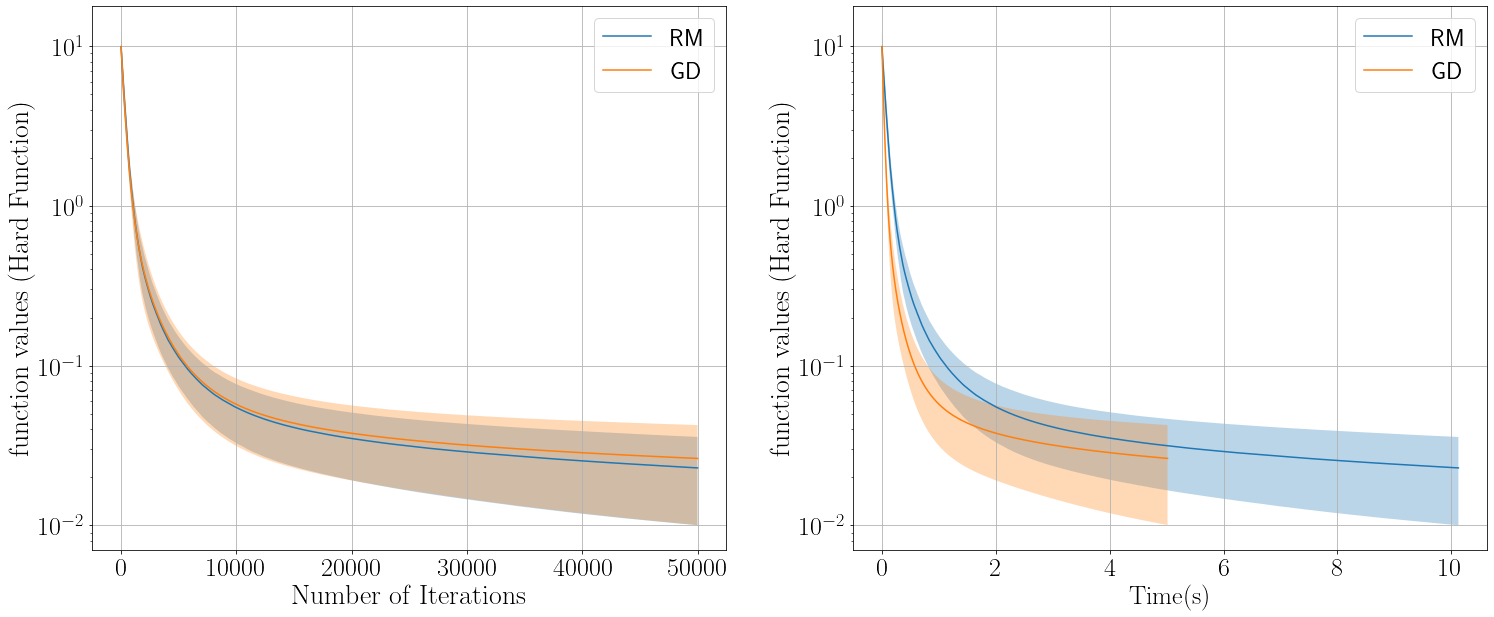

In [21]:
t_p = np.array(range(num_iterations))
t2_p = np.array(range(num_iterations2))
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t_p,f1_pm,label= 'RM')
plt.plot(t2_p,losses_pm,label= 'GD')
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(Hard\;Function)}$', fontdict=font)

plt.fill_between(t_p, f1_pm - f1_p_se, f1_pm + f1_p_se, alpha=0.3)
plt.fill_between(t2_p, losses_pm - losses_p_se, losses_pm + losses_p_se, alpha=0.3)

plt.yscale('log')
# plt.xscale('log')
plt.grid('on')
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(tim_p,f1_pm,label= 'RM')
plt.plot(tim2_p,losses_pm,label= 'GD')

plt.fill_between(tim_p, f1_pm - f1_p_se, f1_pm + f1_p_se, alpha=0.3)
plt.fill_between(tim2_p, losses_pm - losses_p_se, losses_pm + losses_p_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Time(s)}$', fontsize=26)
plt.ylabel(r'$\mathrm{function\; values\;(Hard\;Function)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.grid('on')
plt.savefig('NeurIPS2024/Pics/hardf.pdf', format='pdf')

The SVM test is coded below

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
def load_and_convert_dataset():
    # Load the breast cancer dataset
    cancer = load_breast_cancer()
    A = cancer.data  # Feature matrix
    labels = cancer.target  # Labels

    # Convert labels to 1 and -1
    B = 2 * labels - 1  # Multiply by 2 and subtract 1 to convert 0 to -1 and 1 to 1

    # Preprocess feature matrix A using StandardScaler
    scaler = StandardScaler()
    A = scaler.fit_transform(A)

    return A, B

A, B = load_and_convert_dataset()
print("Shape of A:", A.shape)
print("Shape of B:", B.shape)

Shape of A: (569, 30)
Shape of B: (569,)


In [4]:
a=A
b=B
alpha = 0.7
def phi_alpha(t):
    if t <= 0:
        return 0
    elif 0 < t <= 1:
        return t**2 / 2
    else:
        return (t**alpha - alpha) / alpha + 0.5

def falpha(x):
    m = len(a)
    result = 0
    for i in range(m):
        t = 1 - b[i] * np.dot(a[i], x)
        result += phi_alpha(t)
    return result


def gradient_f(x):
    m, n = len(a), len(x)
    gradient = np.zeros(n)
    for i in range(m):
        t = 1 - b[i] * np.dot(a[i], x)
        if t <= 0:
            grad_phi = 0
        elif 0 < t <= 1:
            grad_phi = -b[i] * a[i] * t
        else:
            grad_phi = -b[i] * a[i] * t**(alpha - 1)
        gradient += grad_phi
    return gradient

In [53]:
num_iterations = 10000
MC = 4
initial = 3
learning_rates = [1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 5e-7, 1e-7]
num_of_lr = len(learning_rates)

execution_time = np.zeros((initial, num_of_lr))
execution_time2 = np.zeros((initial, num_of_lr))
decay_rate_ZO = np.zeros((initial, num_of_lr))
decay_rate_GD = np.zeros((initial, num_of_lr))
f1_h_all = np.zeros((initial, num_of_lr, num_iterations, MC))
losses_h_all = np.zeros((initial, num_of_lr, num_iterations))

for i in range(initial):
    x_0 = np.random.randn(A.shape[1])
    for lr_idx, learning_rate in enumerate(learning_rates):
        ZO_time = 0
        f1_h = np.zeros((num_iterations, MC))
        
        for j in range(MC):
            start = time.time()
            ww = RM(falpha, x_0, num_iterations, h=learning_rate, mu=1e-7)
            end = time.time()
            ZO_time += end - start

            for k in range(num_iterations):
                f1_h[k, j] = falpha(ww[:, k])
        
        execution_time[i, lr_idx] = ZO_time / MC
        f1_hm = np.mean(f1_h, axis=1)
        decay_rate_ZO[i, lr_idx] = f1_hm[-1] / f1_hm[0]
        f1_h_all[i, lr_idx] = f1_h
        
        w = np.zeros((num_iterations, A.shape[1]))
        w[0, :] = x_0
        
        start = time.time()
        for k in range(num_iterations - 1):
            gradd = gradient_f(w[k, :])
            w[k + 1, :] = w[k, :] - learning_rate * gradd
        end = time.time()
        
        execution_time2[i, lr_idx] = end - start
        
        for k in range(num_iterations):
            losses_h_all[i, lr_idx, k] = falpha(w[k, :])
        
        decay_rate_GD[i, lr_idx] = falpha(w[-1, :]) / falpha(w[0, :])
        print(f'Done lr: {learning_rate}')
    print(f'Done Initial: {i}')



Done lr: 0.0001
Done lr: 5e-05
Done lr: 1e-05
Done lr: 5e-06
Done lr: 1e-06
Done lr: 5e-07
Done lr: 1e-07
Done Initial: 0
Done lr: 0.0001
Done lr: 5e-05
Done lr: 1e-05
Done lr: 5e-06
Done lr: 1e-06
Done lr: 5e-07
Done lr: 1e-07
Done Initial: 1
Done lr: 0.0001
Done lr: 5e-05
Done lr: 1e-05
Done lr: 5e-06
Done lr: 1e-06
Done lr: 5e-07
Done lr: 1e-07
Done Initial: 2


In [72]:
mean_execution_time_ZO = np.mean(execution_time, axis=0)
mean_execution_time_GD = np.mean(execution_time2, axis=0)
# mean_decay_rate_ZO = np.mean(decay_rate_ZO, axis=0)
# mean_decay_rate_GD = np.mean(decay_rate_GD, axis=0)
mean_decay_rate_ZO = (1-np.mean(decay_rate_ZO, axis=0))*100
mean_decay_rate_GD = (1-np.mean(decay_rate_GD, axis=0))*100

print("\nSummary Table:")
print("Learning Rate | Mean Time (RM) | Mean Time (GD) | Mean Decay Rate (RM) | Mean Decay Rate (GD)")
for lr_idx, learning_rate in enumerate(learning_rates):
    print(f"{learning_rate:.1e} | {mean_execution_time_ZO[lr_idx]:.4f} | {mean_execution_time_GD[lr_idx]:.4f} | {mean_decay_rate_ZO[lr_idx]:.4f} | {mean_decay_rate_GD[lr_idx]:.4f}")


Summary Table:
Learning Rate | Mean Time (RM) | Mean Time (GD) | Mean Decay Rate (RM) | Mean Decay Rate (GD)
1.0e-04 | 8.8051 | 8.6762 | 97.1698 | 97.1633
5.0e-05 | 8.9252 | 8.7077 | 96.6935 | 96.7137
1.0e-05 | 9.1062 | 8.9664 | 93.8548 | 93.8097
5.0e-06 | 9.1123 | 9.2101 | 91.8412 | 91.8393
1.0e-06 | 9.3738 | 9.7384 | 53.0977 | 83.9349
5.0e-07 | 9.5402 | 10.1902 | 65.2562 | 74.5239
1.0e-07 | 9.9947 | 11.4809 | 45.3681 | 45.1062


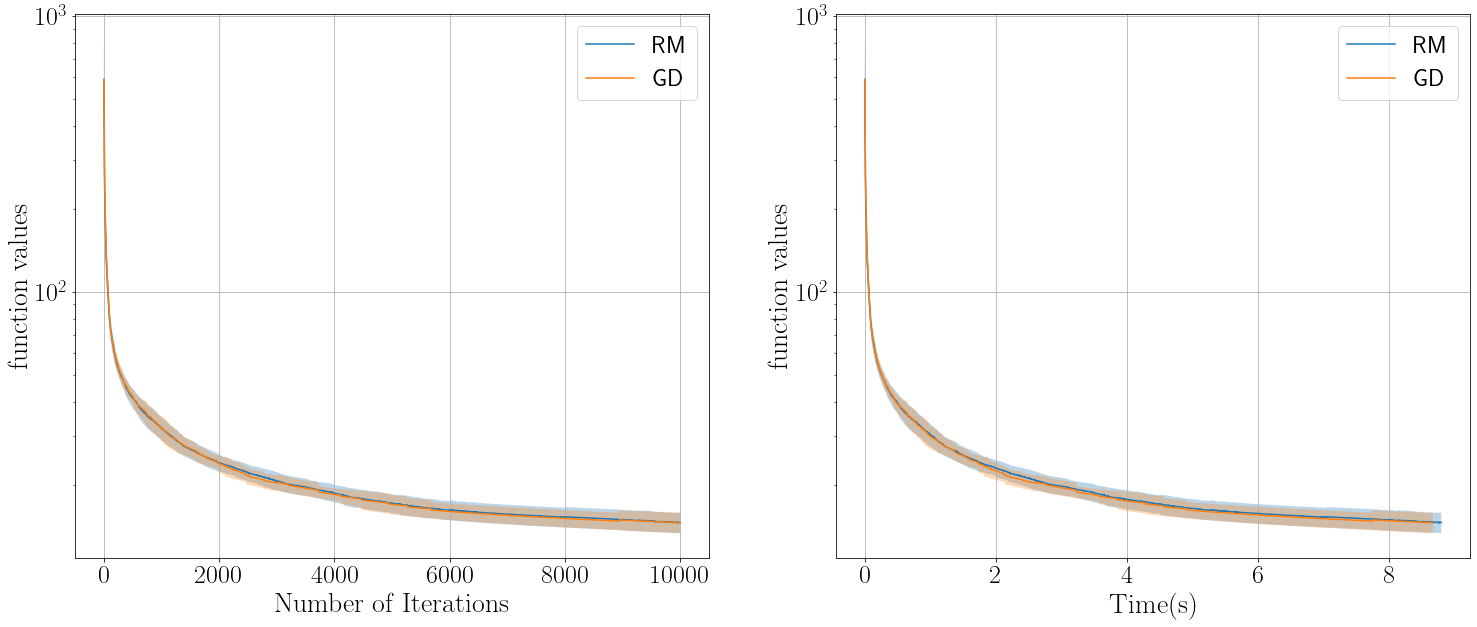

In [64]:
selected_lr_idx = 0
selected_lr = learning_rates[selected_lr_idx]

t_h = np.arange(num_iterations)
tim_h = np.linspace(0, mean_execution_time_ZO[selected_lr_idx], num_iterations)
tim2_h = np.linspace(0, mean_execution_time_GD[selected_lr_idx], num_iterations)

f1_hm = np.mean(f1_h_all[:, selected_lr_idx], axis=(0, 2))
losses_hm = np.mean(losses_h_all[:, selected_lr_idx], axis=0)

f1_h_se = np.std(f1_h_all[:, selected_lr_idx], axis=(0, 2))
losses_h_se = np.std(losses_h_all[:, selected_lr_idx], axis=0)

plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t_h, f1_hm, label='RM')
plt.plot(t_h, losses_hm, label='GD')
plt.fill_between(t_h, f1_hm - f1_h_se, f1_hm + f1_h_se, alpha=0.3)
plt.fill_between(t_h, losses_hm - losses_h_se, losses_hm + losses_h_se, alpha=0.3)
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values}$', fontdict=font)
plt.yscale('log')
plt.grid(True)
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(tim_h, f1_hm, label='RM')
plt.plot(tim2_h, losses_hm, label='GD')
plt.fill_between(tim_h, f1_hm - f1_h_se, f1_hm + f1_h_se, alpha=0.3)
plt.fill_between(tim2_h, losses_hm - losses_h_se, losses_hm + losses_h_se, alpha=0.3)
plt.xlabel(r'$\mathrm{Time(s)}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values}$', fontdict=font)
plt.yscale('log')
plt.grid(True)
plt.legend(loc='best', prop=font1)
plt.savefig('NeurIPS2024/Pics/phi.pdf', format='pdf',bbox_inches='tight')

In [57]:
# np.save('RM_phi.npy', f1_h_all)
# np.save('GD_phi.npy', losses_h_all)
# np.save('tim_phi.npy', execution_time)
# np.save('tim2_phi.npy', execution_time2)
# np.save('decay_rate_ZO_phi.npy', decay_rate_ZO)
# np.save('decay_rate_GD_phi.npy', decay_rate_GD)

# execution_time = np.load('tim_phi.npy')
# execution_time2 = np.load('tim2_phi.npy')
# f1_h_all = np.load('RM_phi.npy')
# losses_h_all = np.load('GD_phi.npy')
# decay_rate_ZO = np.load('decay_rate_ZO_phi.npy')
# decay_rate_GD = np.load('decay_rate_GD_phi.npy')
# num_iterations = 10000



The LDSI test is coded below.

In [11]:
N = 100
T = 500
d = 20
T1 = T // 4
epsilon = 0.1

def create_matrix_A(n):
    # Sample coefficients a from a normal distribution
    a = 0.01*np.random.randn(n)

    # Initialize matrix A with zeros
    A = np.zeros((n, n))

    # Fill upper diagonal with ones
    np.fill_diagonal(A[:,1:], 1)

    # Fill the last row with negative coefficients
    A[-1] = -a[::-1]

    return A
def spectral_radius(matrix):
    """
    Calculate the spectral radius of a matrix.
    """
    eigenvalues, _ = np.linalg.eig(matrix)
    return max(abs(eigenvalues))





def generate_training_data(N, T, d):
    """
    Generate training data according to the given specifications.
    """

    # Generate input sequences x and output sequences y
    x = np.random.randn(N, T)
    y = np.zeros((N, T))
    h = np.zeros((N, T+1, d))  # Hidden states
    for i in range(N):
        for t in range(T):
            h[i, t+1] = (np.dot(A, h[i, t]).reshape(-1, 1)+ np.dot(B, x[i, t])).ravel()
            y[i, t] = np.dot(C, h[i, t]) + np.dot(D, x[i, t]) + 0.01*np.random.randn()
    
    return x, y

def combine_params(A, C, D):
    # Flatten matrix A to a 1D array
    A_flat = A.flatten().reshape(-1,1)
    
    # Concatenate A_flat, C, and D into a single vector
    combined_vector = np.concatenate((A_flat, C.T, [D]))

    return combined_vector

def split_params(combined_vector, d):
    # Extract matrix A from combined_vector
    A_size = d * d
    A = combined_vector[:A_size].reshape(d, d)

    # Extract vector C from combined_vector
    C = combined_vector[A_size:A_size + d]

    # Extract scalar D from combined_vector
    D = combined_vector[-1]

    return A, C, D


def evaluate_loss(theta_hat_0):
    """
    Evaluate the loss function for the given parameters theta_hat.
    """
    A_hat, C_hat, D_hat = split_params(theta_hat_0,d)
    C_hat = C_hat.T
    M = x.shape[0]  # Number of training examples
    T = x.shape[1]  # Length of each sequence
    
    loss = 0
    for i in range(M):
        h_hat = np.zeros((T+1, d))  # Estimated hidden states
        h_hat[0] = np.zeros(d)  # Initial estimated hidden state
        
    
        for t in range(T1, T):
            h_hat[t+1] = (np.dot(A_hat, h_hat[t]).reshape(-1, 1)+ np.dot(B, x[i, t])).ravel()
            y_hat = np.dot(C_hat, h_hat[t]) + np.dot(D_hat, x[i, t])
            loss += np.linalg.norm(y_hat - y[i, t])**2
    
    loss /= (M * (T - T1))
    
    return loss

def perturb_parameters(true_A, true_C, true_D, epsilon):
    """
    Perturb the true parameters to obtain perturbed parameters while
    ensuring the spectral radius of A_hat is less than 1.
    """
    A_hat = create_matrix_A(d) 
    A_hat[-1,:] = true_A[-1,:] + epsilon * np.random.randn(d)
    
    C_hat = true_C + epsilon * np.random.randn(*true_C.shape)
    D_hat = true_D + epsilon * np.random.randn(*true_D.shape)
    
    return A_hat, C_hat, D_hat

def gradient_loss(theta_hat):
    """
    Compute the gradient of the loss function with respect to theta_hat.
    """
    A_hat, C_hat, D_hat = split_params(theta_hat, d)
    C_hat = C_hat.T
    M = x.shape[0]  # Number of training examples
    T = x.shape[1]  # Length of each sequence
    
    grad_A = np.zeros((d, d))
    grad_C = np.zeros((1, d))
    grad_D = 0
    
    for i in range(M):
        h_hat = np.zeros((T+1, d))  # Estimated hidden states
        h_hat[0] = np.zeros(d)  # Initial estimated hidden state
        
        for t in range(T1, T):
            # Compute gradients of A_hat, C_hat, and D_hat
            h_hat[t+1] = (np.dot(A_hat, h_hat[t]).reshape(-1, 1)+ np.dot(B, x[i, t])).ravel()
            y_hat = np.dot(C_hat, h_hat[t]) + np.dot(D_hat, x[i, t])
            
            grad_D += 2 * (y_hat - y[i, t]) * x[i, t]
            grad_C += 2 * np.dot((y_hat - y[i, t]).reshape(1, -1), h_hat[t].reshape(1, -1))
            grad_A += 2 * (y_hat - y[i, t]).reshape(-1, 1)* C_hat.T* h_hat[t-1]
    
    grad_A /= (M * (T - T1))
    grad_C /= (M * (T - T1))
    grad_D /= (M * (T - T1))
    
    # Flatten gradients into a single vector
    grad_theta = combine_params(grad_A, grad_C, grad_D)
    
    return grad_theta

for i in range(10):
    AA = create_matrix_A(d)
    if spectral_radius(AA) < 1:
        A = AA
        break
    
B = np.zeros((d, 1))
B[-1] = 1

C = np.random.randn(1, d)
D = np.random.randn(1)

x, y= generate_training_data(N, T, d)
# Perturb parameters
A_hat_0, C_hat_0, D_hat_0 = perturb_parameters(A, C, D, epsilon)

theta_hat_0 = combine_params(A_hat_0, C_hat_0, D_hat_0)
loss = evaluate_loss(theta_hat_0)
print("Loss:", loss)
# print("gradient", gradient_loss(w[0,:].reshape(-1,1)))

num_iterations = 1000
learning_rate = 0.00001
learning_rate2 = 0.0001
num_iterations2 = 1000

Loss: 9.61139980755858


In [14]:
MC = 5
execution_time = []
execution_time2 = []
execution_time3 = []
f1 = np.zeros((num_iterations,MC))
losses = np.zeros((num_iterations2,MC))
losses2 = np.zeros((num_iterations2,MC))
for i in range(10):
    AA = create_matrix_A(d)
    if spectral_radius(AA) < 1:
        A = AA
        break
    
B = np.zeros((d, 1))
B[-1] = 1

C = np.random.randn(1, d)
D = np.random.randn(1)

x, y= generate_training_data(N, T, d)

for j in range(MC):
    # Perturb parameters
    while(True):
        A_hat_0, C_hat_0, D_hat_0 = perturb_parameters(A, C, D, epsilon)
        theta_hat_0 = combine_params(A_hat_0, C_hat_0, D_hat_0)
        if evaluate_loss(theta_hat_0)>5 and evaluate_loss(theta_hat_0)<20:
            break
    print(evaluate_loss(theta_hat_0))
    start = time.time()
    ww=RM(evaluate_loss,theta_hat_0,num_iterations,h = 0.00001,mu=0.0001)
    end = time.time()
    execution_time.append(end-start)

    for i in range(num_iterations):
        f1[i,j] = evaluate_loss(ww[:,i])

    w = np.zeros((num_iterations2,np.shape(theta_hat_0)[0]))
    w[0,:]=theta_hat_0.ravel()

    # Gradient Descent
    start = time.time()
    for i in range(num_iterations2-1):
        # Compute gradient
        grad_theta = gradient_loss(w[i,:].reshape(-1,1)).ravel()
        # Update weights
        w[i+1,:] =w[i,:]-learning_rate * grad_theta
        # Compute loss
    end = time.time()
    execution_time2.append(end-start)

    for i in range(num_iterations2):
        # Compute loss
        current_loss = evaluate_loss(w[i,:])
        losses[i,j] = current_loss

    w1 = np.zeros((num_iterations2,np.shape(theta_hat_0)[0]))
    w1[0,:]=theta_hat_0.ravel()

    # Gradient Descent
    start = time.time()
    for i in range(num_iterations2-1):
        # Compute gradient
        grad_theta = gradient_loss(w1[i,:].reshape(-1,1)).ravel()
        # if np.linalg.norm(grad_theta)>=50:
        #     grad_theta = grad_theta/np.linalg.norm(grad_theta)*10
        # Update weights
        w1[i+1,:] =w1[i,:]-learning_rate2 * grad_theta
        # Compute loss
    end = time.time()
    execution_time3.append(end-start)

    for i in range(num_iterations2):
        # Compute loss
        current_loss = evaluate_loss(w1[i,:])
        losses2[i,j] = current_loss


et = np.mean(execution_time)
et2 = np.mean(execution_time2)
et3 = np.mean(execution_time3)
tim = np.linspace(0,et,num_iterations)
tim2 = np.linspace(0,et2,num_iterations2)
tim3 = np.linspace(0,et3,num_iterations2)
f1_a = np.mean(f1,axis=1)
losses_a = np.mean(losses,axis=1)
losses2_a = np.mean(losses2,axis=1)

f1_se = np.std(f1, axis=1)
losses_se = np.std(losses, axis=1)
losses2_se = np.std(losses2, axis=1)

7.583087204446901
6.275809877274226
9.174764662421067
5.186295300010213
5.104319725790883


In [7]:
# np.save('RM_losses.npy', f1)
# np.save('GD_losses.npy', losses)
# np.save('GD_losses_clip.npy', losses2)
# np.save('tim.npy', tim)
# np.save('tim2.npy', tim2)
# np.save('tim3.npy', tim3)
# np.save('et.npy',execution_time)
# np.save('et2.npy',execution_time2)
# np.save('et3.npy',execution_time3)

# f1 = np.load('RM_losses.npy')
# losses = np.load('GD_losses.npy')
# losses2 = np.load('GD_losses_clip.npy')
# f1_a = np.mean(f1,axis=1)
# losses_a = np.mean(losses,axis=1)
# losses2_a = np.mean(losses2,axis=1)
# tim = np.load('tim.npy')
# tim2 = np.load('tim2.npy')
# tim3 = np.load('tim3.npy')
# num_iterations = 1000
# num_iterations2= 1000

# f1_se = np.std(f1, axis=1)
# losses_se = np.std(losses, axis=1)
# losses2_se = np.std(losses2, axis=1)

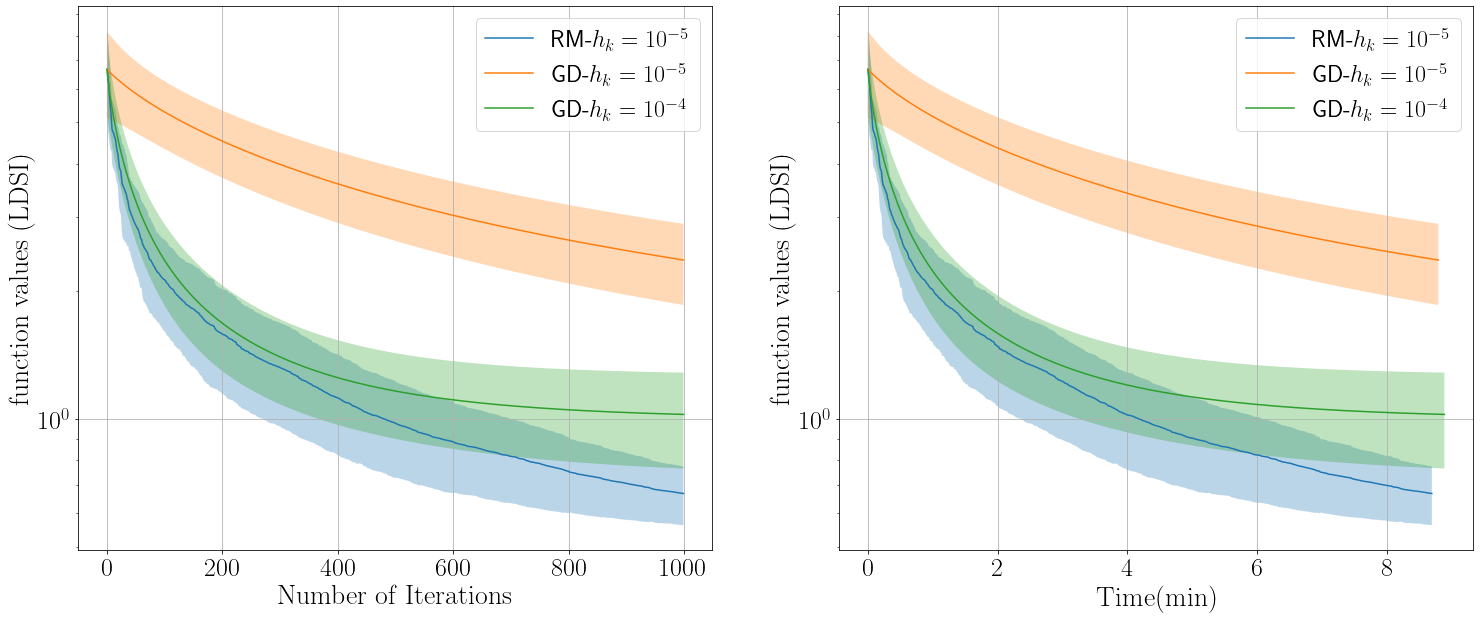

In [8]:
t = np.array(range(num_iterations))
t2 = np.array(range(num_iterations2))
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t,f1_a,label= r'RM-$h_k = 10^{-5}$')
plt.plot(t2,losses_a,label= r'GD-$h_k = 10^{-5}$')
plt.plot(t2,losses2_a,label= r'GD-$h_k = 10^{-4}$')

plt.fill_between(t, f1_a - f1_se, f1_a + f1_se, alpha=0.3)
plt.fill_between(t2, losses_a - losses_se, losses_a + losses_se, alpha=0.3)
plt.fill_between(t2, losses2_a - losses2_se, losses2_a + losses2_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(LDSI)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.grid('on')
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(tim/60,f1_a,label= r'RM-$h_k = 10^{-5}$')
plt.plot(tim2/60,losses_a,label= r'GD-$h_k = 10^{-5}$')
plt.plot(tim3/60,losses2_a,label= r'GD-$h_k = 10^{-4}$')

plt.fill_between(tim/60, f1_a - f1_se, f1_a + f1_se, alpha=0.3)
plt.fill_between(tim2/60, losses_a - losses_se, losses_a + losses_se, alpha=0.3)
plt.fill_between(tim3/60, losses2_a - losses2_se, losses2_a + losses2_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Time(min)}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(LDSI)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.grid('on')
plt.savefig('NeurIPS2024/Pics/LDSI.pdf', format='pdf')

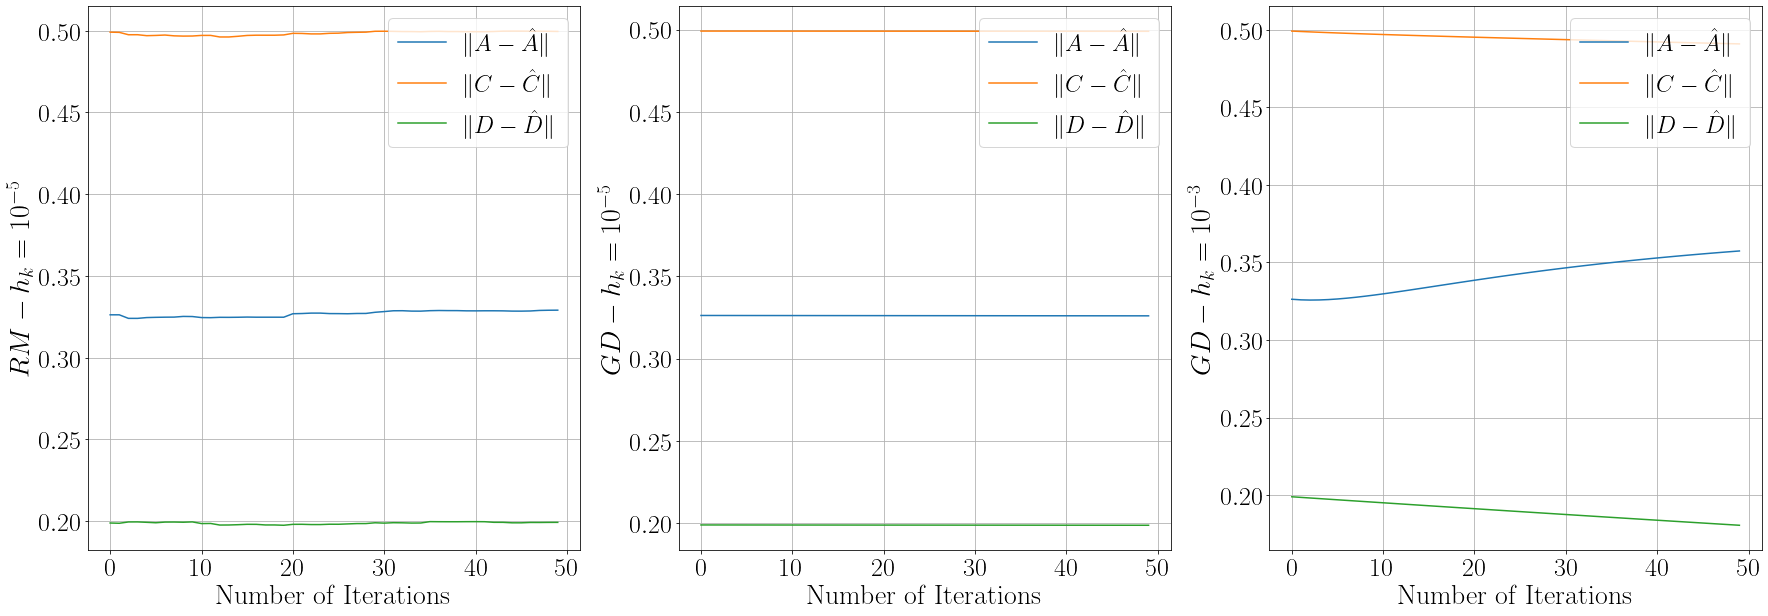

In [131]:
normAR=[]
normCR=[]
normDR=[]
for i in range(num_iterations):
    A_hat, C_hat, D_hat = split_params(ww[:,i],d)
    C_hat = C_hat.T
    normAR.append(np.linalg.norm(A-A_hat))
    normCR.append(np.linalg.norm(C-C_hat))
    normDR.append(np.linalg.norm(D-D_hat))

normAG1=[]
normCG1=[]
normDG1=[]
for i in range(num_iterations):
    A_hat, C_hat, D_hat = split_params(w[i,:],d)
    C_hat = C_hat.T
    normAG1.append(np.linalg.norm(A-A_hat))
    normCG1.append(np.linalg.norm(C-C_hat))
    normDG1.append(np.linalg.norm(D-D_hat))

normAG2=[]
normCG2=[]
normDG2=[]
for i in range(num_iterations):
    A_hat, C_hat, D_hat = split_params(w1[i,:],d)
    C_hat = C_hat.T
    normAG2.append(np.linalg.norm(A-A_hat))
    normCG2.append(np.linalg.norm(C-C_hat))
    normDG2.append(np.linalg.norm(D-D_hat))

plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t,normAR,label= r'$\|A-\hat{A}\|$')
plt.plot(t,normCR,label= r'$\|C-\hat{C}\|$')
plt.plot(t,normDR,label= r'$\|D-\hat{D}\|$')
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$RM-h_k=10^{-5}$', fontdict=font)
# plt.yscale('log')
# plt.xscale('log')
plt.grid('on')
plt.legend(loc='best', prop=font1)

plt.subplot(1,3,2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t,normAG1,label= r'$\|A-\hat{A}\|$')
plt.plot(t,normCG1,label= r'$\|C-\hat{C}\|$')
plt.plot(t,normDG1,label= r'$\|D-\hat{D}\|$')
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$GD-h_k=10^{-5}$', fontdict=font)
# plt.yscale('log')
# plt.xscale('log')
plt.grid('on')
plt.legend(loc='best', prop=font1)

plt.subplot(1,3,3)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t,normAG2,label= r'$\|A-\hat{A}\|$')
plt.plot(t,normCG2,label= r'$\|C-\hat{C}\|$')
plt.plot(t,normDG2,label= r'$\|D-\hat{D}\|$')
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$GD-h_k=10^{-3}$', fontdict=font)
# plt.yscale('log')
# plt.xscale('log')
plt.grid('on')
plt.legend(loc='best', prop=font1)